In [1]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn import metrics

from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Global Path

In [2]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure2/'

# Data

In [3]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]

In [4]:
ec_color = df(index=gene_sets['NREC_profile'] + gene_sets['REC_profile'], columns=['colors'])
ec_color.loc[gene_sets['NREC_profile'], 'colors'] = 'crimson'
ec_color.loc[gene_sets['REC_profile'], 'colors'] = 'royalblue'

In [5]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [6]:
lung_sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/LUNG/lung_2020_tash_sig_info.csv',
                            header=0, index_col=0, sep=',')

In [7]:
lung_sig_info['cell_mfc_name'].value_counts()

A549        8084
HCC515      2377
H1299        120
SALE          51
NCIH596       40
NCIH2073      36
SKLU1         15
NCIH1694      14
H1975         11
T3M10         10
NCIH1975      10
DV90          10
HCC15          8
CORL23         7
NCIH1836       7
HCC827         1
Name: cell_mfc_name, dtype: int64

In [8]:
sub_A549 = lung_sig_info[lung_sig_info['cell_mfc_name'] == 'A549'].index

In [9]:
# shRNA perturbations that targeting these genes should be able to inhibit the expression of sig_defc_91061_up
## read original lv5 signature matrix
lung_trt_sh_original = pd.read_csv(data_home + '/CMAP2020_Cancer/LUNG/CMAP2020_lv5_trt_sh_merged.csv',
                                   header=0, index_col=0, sep=',')
lung_trt_sh_original.index = lung_trt_sh_original.index.astype(int)
lung_trt_sh_original = lung_trt_sh_original[lung_trt_sh_original.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

In [10]:
shift_shRNA = pd.read_csv(poseidon_home + 'shift_ability/LUNG_trt_sh.csv', header=0, index_col=0, sep=',')

In [11]:
shift_shRNA = shift_shRNA[shift_shRNA.index.isin(sub_A549)]

# Shift ability of shRNAs

In [12]:
# experiments directly targeting NREC and REC
tar_dir_EC = shift_shRNA[shift_shRNA['cmap_name'].isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])].index

In [13]:
tar_dir_EC

Index(['TA.KD009_A549_96H:TRCN0000009851:1', 'KDB005_A549_96H:J22',
       'KDB001_A549_96H:TRCN0000245528:-666',
       'KDB001_A549_96H:TRCN0000292376:-666',
       'KDA004_A549_96H:TRCN0000003474:-666',
       'KDB005_A549_96H:TRCN0000019575:-666', 'KDB005_A549_96H:K17',
       'KDB005_A549_96H:TRCN0000045680:-666',
       'KDA008_A549_96H:TRCN0000004243:-666',
       'KDB002_A549_96H:TRCN0000179943:-666',
       ...
       'KDD004_A549_96H:TRCN0000043564:-666',
       'KDC005_A549_96H:TRCN0000035474:-666',
       'KDB007_A549_96H:TRCN0000006405:-666',
       'KDB009_A549_96H:TRCN0000029753:-666',
       'KDD002_A549_96H:TRCN0000007229:-666',
       'KDB006_A549_96H:TRCN0000008794:-666',
       'KDD004_A549_96H:TRCN0000007229:-666',
       'KDC010_A549_96H:TRCN0000004767:-666',
       'KDA004_A549_96H:TRCN0000006405:-666',
       'KDB010_A549_96H:TRCN0000195049:-666'],
      dtype='object', length=322)

In [14]:
# KO eff available
ko_eff = lung_trt_sh_original[lung_trt_sh_original.index.isin(df(shift_shRNA.loc[tar_dir_EC, 'cmap_name'])['cmap_name'])].index

In [15]:
ko_eff_cal = df(index=tar_dir_EC, columns=['zexpr_lv5', 'gene'])
for exp in tar_dir_EC:
    ko_eff_cal.at[exp, 'zexpr_lv5'] = lung_trt_sh_original.loc[shift_shRNA.loc[exp, 'cmap_name'], exp]
    ko_eff_cal.at[exp, 'gene'] = shift_shRNA.loc[exp, 'cmap_name']

In [16]:
# select the experiments with KO efficiency greater than 1.5 (z-score, decrease at 1.5 std)
top_ko_eff = ko_eff_cal[ko_eff_cal['zexpr_lv5'] <= -1]
top_ko_eff.shape

(133, 2)

In [17]:
top_ko_eff['NREC_enr'] = shift_shRNA['NREC_profile']
top_ko_eff['REC_enr'] = shift_shRNA['REC_profile']
top_ko_eff['shift_ability'] = shift_shRNA['shift_ability']

<ipython-input-17-114ec2009237>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ko_eff['NREC_enr'] = shift_shRNA['NREC_profile']
<ipython-input-17-114ec2009237>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ko_eff['REC_enr'] = shift_shRNA['REC_profile']
<ipython-input-17-114ec2009237>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [18]:
top_ko_eff_nrec = top_ko_eff[top_ko_eff['gene'].isin(gene_sets['NREC_profile'])]
top_ko_eff_nrec

,zexpr_lv5,gene,NREC_enr,REC_enr,shift_ability
TA.KD009_A549_96H:TRCN0000009851:1,-1.86959,MET,-0.309542,0.469427,0.778968
KDB001_A549_96H:TRCN0000245528:-666,-1.43325,PSRC1,-0.309762,0.452638,0.762400
KDB001_A549_96H:TRCN0000292376:-666,-2.3323,NUSAP1,-0.364706,0.389904,0.754610
KDB005_A549_96H:TRCN0000019575:-666,-5.1022,MCM3,-0.312674,0.409659,0.722333
KDB005_A549_96H:K17,-5.1022,MCM3,-0.312674,0.409659,0.722333
...,...,...,...,...,...
KDB005_A549_96H:I03,-2.8582,MCM3,0.225142,-0.346297,-0.571439
KDB006_A549_96H:TRCN0000038981:-666,-3.31725,PYCR1,0.214462,-0.375815,-0.590277
KDB006_A549_96H:TRCN0000008794:-666,-7.05793,DNAJB1,0.303551,-0.348855,-0.652406
KDA004_A549_96H:TRCN0000006405:-666,-1.49426,EPHA2,0.314374,-0.424876,-0.739250


In [19]:
top_ko_eff_rec = top_ko_eff[top_ko_eff['gene'].isin(gene_sets['REC_profile'])]
top_ko_eff_rec

,zexpr_lv5,gene,NREC_enr,REC_enr,shift_ability
KDB004_A549_96H:TRCN0000021067:-666,-3.12204,ID2,-0.282014,0.273204,0.555217
KDA001_A549_96H:TRCN0000008027:-666,-1.89722,MYD88,-0.255073,0.197127,0.452200
KDB008_A549_96H:TRCN0000062711:-666,-2.55505,BID,-0.261971,-0.255788,0.006183
KDB004_A549_96H:TRCN0000036225:-666,-4.28196,GLRX,-0.204184,-0.239251,-0.035067
TA.KD010_A549_96H:TRCN0000029594:1,-1.24787,ITGAL,-0.162072,-0.253226,-0.091154
KDB004_A549_96H:TRCN0000021064:-666,-2.03213,ID2,0.170269,-0.310764,-0.481033
KDC004_A549_96H:TRCN0000007229:-666,-1.13272,CFLAR,0.269438,-0.309456,-0.578893
KDD002_A549_96H:TRCN0000007229:-666,-1.36973,CFLAR,0.221657,-0.426409,-0.648066
KDD004_A549_96H:TRCN0000007229:-666,-2.87307,CFLAR,0.263543,-0.397589,-0.661132


In [20]:
top_ko_eff.loc[top_ko_eff_nrec.index, 'EC_profile'] = 'crimson'
top_ko_eff.loc[top_ko_eff_rec.index, 'EC_profile'] = 'royalblue'

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [21]:
top_ko_eff_merged = lung_trt_sh_original[list(top_ko_eff_nrec.index) + list(top_ko_eff_rec.index)]

In [22]:
top_ko_eff_merged_ec = top_ko_eff_merged[top_ko_eff_merged.index.isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])]

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


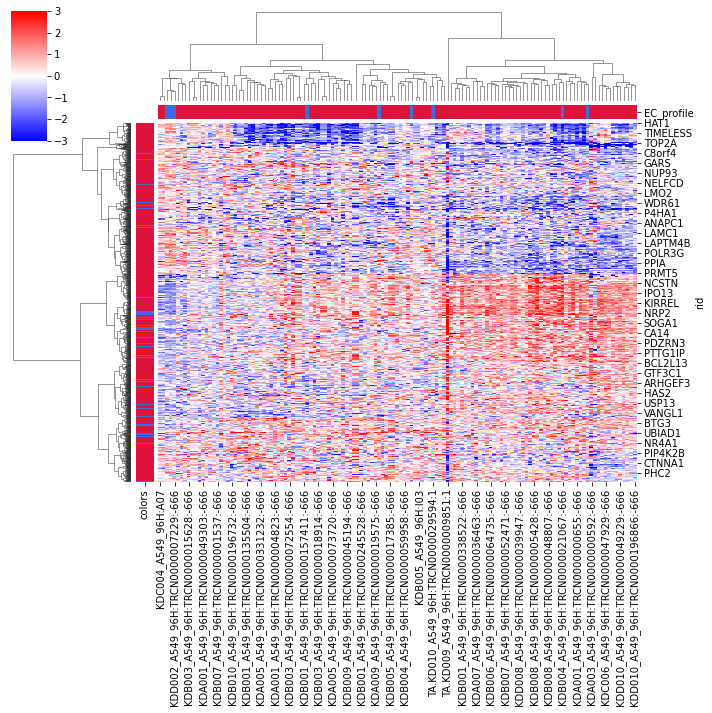

In [55]:
sns.clustermap(top_ko_eff_merged_ec,
               vmin=-3, vmax=3, cmap='bwr', method='ward',
               col_colors=top_ko_eff['EC_profile'],
               row_colors=ec_color['colors'])

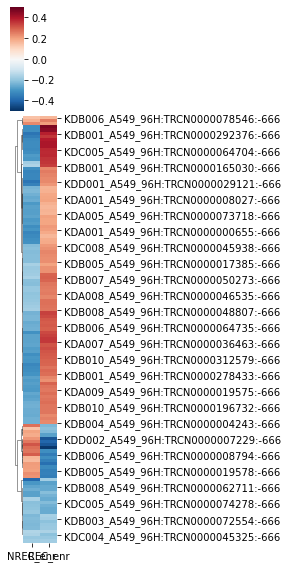

In [56]:
sns.clustermap(top_ko_eff[['NREC_enr', 'REC_enr']],
               figsize=(4, 8),
               row_cluster=True, col_cluster=False,
               cmap='RdBu_r', vmin=-.5, vmax=.5)

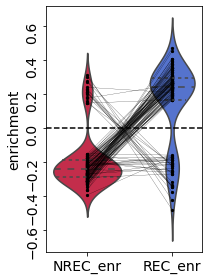

In [60]:
plt.figure(figsize=(3, 4))
sns.violinplot(x='variable', y='value',
               inner='quartile',
               data=pd.melt(top_ko_eff.loc[top_ko_eff_nrec.index, ['NREC_enr', 'REC_enr']]),
               palette={'NREC_enr': 'crimson', 'REC_enr': 'royalblue'})

plt.scatter(np.zeros(len(top_ko_eff_nrec.index)), top_ko_eff.loc[top_ko_eff_nrec.index, 'NREC_enr'], s=5, c='k')
plt.scatter(np.ones(len(top_ko_eff_nrec.index)), top_ko_eff.loc[top_ko_eff_nrec.index, 'REC_enr'], s=5, c='k')
for i in top_ko_eff_nrec.index:
    plt.plot([0, 1], [top_ko_eff.loc[i, 'NREC_enr'], top_ko_eff.loc[i, 'REC_enr']], c='k', linewidth=0.2)

plt.axhline(y=0., c='k', ls='--')
plt.ylabel('enrichment', fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/direct_target_A549/NREC_targeted.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/direct_target_A549/NREC_targeted.pdf', transparent=True)

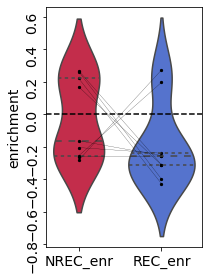

In [61]:
plt.figure(figsize=(3, 4))
sns.violinplot(x='variable', y='value',
               inner='quartile',
               data=pd.melt(top_ko_eff.loc[top_ko_eff_rec.index, ['NREC_enr', 'REC_enr']]),
               palette={'NREC_enr': 'crimson', 'REC_enr': 'royalblue'})

plt.scatter(np.zeros(len(top_ko_eff_rec.index)), top_ko_eff.loc[top_ko_eff_rec.index, 'NREC_enr'], s=5, c='k')
plt.scatter(np.ones(len(top_ko_eff_rec.index)), top_ko_eff.loc[top_ko_eff_rec.index, 'REC_enr'], s=5, c='k')
for i in top_ko_eff_rec.index:
    plt.plot([0, 1], [top_ko_eff.loc[i, 'NREC_enr'], top_ko_eff.loc[i, 'REC_enr']], c='k', linewidth=0.2)

plt.axhline(y=0., c='k', ls='--')
plt.ylabel('enrichment', fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/direct_target_A549/REC_targeted.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/direct_target_A549/REC_targeted.pdf', transparent=True)# 

In [23]:
shift_shRNA_tar_dir = shift_shRNA[shift_shRNA.index.isin(tar_dir_EC)]

In [24]:
for g in shift_shRNA_tar_dir.index:
    shift_shRNA_tar_dir.at[g, 'EC_profile'] = ec_color.loc[shift_shRNA_tar_dir.loc[g, 'cmap_name'], 'colors']

In [25]:
shift_shRNA_tar_dir

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,EC_profile
TA.KD009_A549_96H:TRCN0000009851:1,-0.309542,0.469427,MET,NaN,1 uL,0.778968,crimson
KDB005_A549_96H:J22,-0.368420,0.396064,TARS,NaN,NaN,0.764484,crimson
KDB001_A549_96H:TRCN0000245528:-666,-0.309762,0.452638,PSRC1,NaN,NaN,0.762400,crimson
KDB001_A549_96H:TRCN0000292376:-666,-0.364706,0.389904,NUSAP1,NaN,NaN,0.754610,crimson
KDA004_A549_96H:TRCN0000003474:-666,-0.302082,0.437783,SMURF1,NaN,NaN,0.739865,crimson
...,...,...,...,...,...,...,...
KDB006_A549_96H:TRCN0000008794:-666,0.303551,-0.348855,DNAJB1,NaN,NaN,-0.652406,crimson
KDD004_A549_96H:TRCN0000007229:-666,0.263543,-0.397589,CFLAR,NaN,NaN,-0.661132,royalblue
KDC010_A549_96H:TRCN0000004767:-666,0.251917,-0.428442,ACACA,NaN,NaN,-0.680358,crimson
KDA004_A549_96H:TRCN0000006405:-666,0.314374,-0.424876,EPHA2,NaN,NaN,-0.739250,crimson


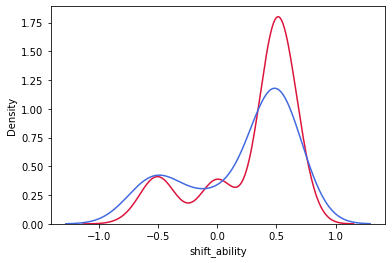

In [12]:
for c in shift_shRNA_tar_dir['EC_profile'].unique():
    sns.kdeplot(x='shift_ability', data=shift_shRNA_tar_dir[shift_shRNA_tar_dir['EC_profile'] == c], color=c)

In [26]:
top_ko_shRNA_shift = shift_shRNA[shift_shRNA.index.isin(top_ko_eff.index)]

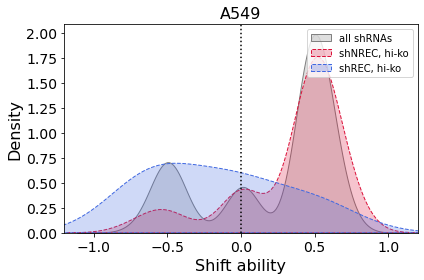

In [65]:
plt.figure(figsize=(6, 4))
sns.kdeplot(x='shift_ability', data=shift_shRNA,
            # cumulative=True,
            label='all shRNAs', fill=True, color='grey')
# sns.rugplot(x='modified', data=shRNA_shift, color='grey')
sns.kdeplot(x='shift_ability', data=shift_shRNA[shift_shRNA.index.isin(top_ko_eff_nrec.index)],
            # cumulative=True,
            label='shNREC, hi-ko', fill=True, color='crimson', ls='--')
# sns.rugplot(x='modified', data=shRNA_shift[shRNA_shift.index.isin(top_ko_eff_nrec.index)], color='crimson')
sns.kdeplot(x='shift_ability', data=shift_shRNA[shift_shRNA.index.isin(top_ko_eff_rec.index)],
            # cumulative=True,
            label='shREC, hi-ko', fill=True, color='royalblue', ls='--')
# sns.rugplot(x='modified', data=shRNA_shift[shRNA_shift.index.isin(top_ko_eff_rec.index)], color='royalblue')
plt.title('A549', fontsize=16)
plt.xlabel('Shift ability', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.axvline(x=0, ls=':', c='k')
plt.xlim(-1.2, 1.2)
plt.legend()
plt.yticks(rotation=0, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/shift_ability/A549.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/shift_ability/A549.pdf', transparent=True)

In [28]:
stats.ks_2samp(shift_shRNA[shift_shRNA.index.isin(top_ko_eff_nrec.index)]['shift_ability'],
               shift_shRNA[shift_shRNA.index.isin(top_ko_eff_rec.index)]['shift_ability'])

KstestResult(statistic=0.600358422939068, pvalue=0.002067242393139823)

In [67]:
top_ko_shRNA_shift.loc[top_ko_eff_nrec.index, 'EC_profile'] = 'shNREC'
top_ko_shRNA_shift.loc[top_ko_eff_rec.index, 'EC_profile'] = 'shREC'

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


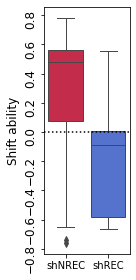

In [68]:
plt.figure(figsize=(2, 4))
sns.boxplot(x='EC_profile', y='shift_ability', data=top_ko_shRNA_shift,
            palette={'shNREC': 'crimson', 'shREC': 'royalblue'},
            linewidth=1)
plt.xlabel('')
plt.ylabel('Shift ability', fontsize=12)
plt.yticks(rotation=90, fontsize=12)
plt.axhline(y=0., c='k', ls=':')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/shift_ability/A549_boxplot.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/shift_ability/A549_boxplot.pdf', transparent=True)